In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


In [41]:
raw.columns

Index(['id_str', 'created_at', 'follower_count', 'friends_count', 'statefips',
       'countyfips', 'countyname', 'is_urban', 'ogtext', 'cleantext',
       'mentions', 'hashtags', 'pos', 'ner', 'sentiment', 'sent_confidence',
       'date', 'week', 'time', 'hour', 'is_negative', 'is_positive',
       'state_name', 'state_abv', 'fips', 'count'],
      dtype='object')

In [42]:
keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')

there are a total of 53272 tweets after subsetting for cdc keywords


# getting counties by rural/urban

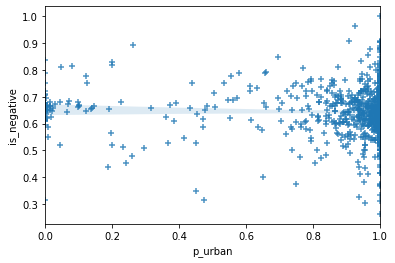

In [43]:
df = raw.groupby(['fips']).agg({'count':'count', 'is_urban':'sum', 'is_negative':'mean'}).reset_index()
df['is_rural'] = df['count'] - df['is_urban']
df['p_urban'] = df['is_urban'] / df['count']

df = df[df['count'] > 15]

sns.regplot(y='is_negative', x='p_urban', data=df, marker='+')

In [44]:
df.corr()**2

,count,is_urban,is_negative,is_rural,p_urban
count,1.000000,0.911010,0.001428,0.069678,0.001147
is_urban,0.911010,1.000000,0.001950,0.001281,0.015457
is_negative,0.001428,0.001950,1.000000,0.000262,0.000741
is_rural,0.069678,0.001281,0.000262,1.000000,0.265700
p_urban,0.001147,0.015457,0.000741,0.265700,1.000000


In [52]:
import scipy
x= df['p_urban']
y= df['is_negative']

print(scipy.stats.pearsonr(x, y))

(nan, nan)


# t test between urban and rural counties

In [46]:
print(len(df.index))

df2 = df[df['p_urban'] < 0.8]
df2 = df2[df2['p_urban'] > 0.2]
df2.describe()

919


,count,is_urban,is_negative,is_rural,p_urban
count,81.000000,81.000000,81.000000,81.000000,81.000000
mean,119.382716,65.271605,0.641258,54.111111,0.610725
std,223.230462,98.892494,0.109448,129.853764,0.169797
min,16.000000,5.000000,0.315789,4.000000,0.227273
25%,23.000000,14.000000,0.586207,9.000000,0.473684
50%,51.000000,29.000000,0.653846,17.000000,0.657895
75%,107.000000,67.000000,0.722222,35.000000,0.761905
max,1178.000000,555.000000,0.894737,686.000000,0.797688


len urban= 830, len rural= 182
-0.544046158294628 0.5869227574492827


Text(0.5, 1.0, 'COVID-19 Dataset')

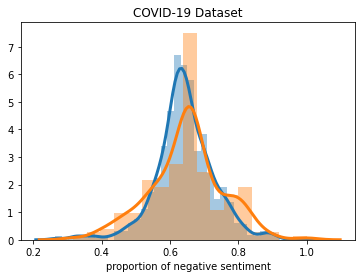

In [50]:
urban = raw[raw['is_urban']==1].groupby(['fips']).agg({'count':'count', 'is_negative':'mean'}).reset_index()
rural = raw[raw['is_urban']==0].groupby(['fips']).agg({'count':'count', 'is_negative':'mean'}).reset_index()

urban = urban[urban['count'] > 15]
rural = rural[rural['count'] > 15]

print(f'len urban= {len(urban.index)}, len rural= {len(rural.index)}')

from scipy.stats import ttest_ind
t, p = ttest_ind(urban['is_negative'], rural['is_negative'], equal_var=False)
print(t, p)

sns.distplot(urban['is_negative'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3}, label="urban")

sns.distplot(rural['is_negative'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3}, label="rural", axlabel="proportion of negative sentiment")

plt.title("COVID-19 Dataset")

len urban= 355, len rural= 52
-3.025690008919648 0.0034697721999694185


Text(0.5, 1.0, 'CDC Subset')

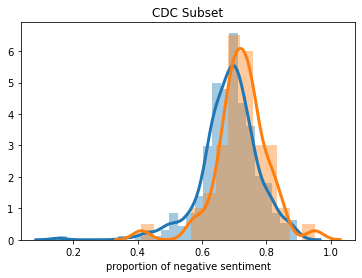

In [51]:
urban = cdc[cdc['is_urban']==1].groupby(['fips']).agg({'count':'count', 'is_negative':'mean'}).reset_index()
rural = cdc[cdc['is_urban']==0].groupby(['fips']).agg({'count':'count', 'is_negative':'mean'}).reset_index()

urban = urban[urban['count'] > 15]
rural = rural[rural['count'] > 15]

print(f'len urban= {len(urban.index)}, len rural= {len(rural.index)}')

from scipy.stats import ttest_ind
t, p = ttest_ind(urban['is_negative'], rural['is_negative'], equal_var=False)
print(t, p)

sns.distplot(urban['is_negative'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3}, label="urban")

sns.distplot(rural['is_negative'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3}, label="rural", axlabel="proportion of negative sentiment")

plt.title("CDC Subset")